## Ejercicio Práctico - Clase 2 VPC2 - 4co2022

Generar una red convolucional con las siguientes caracteristicas:

*   Conv1: cantidad de filtros=16, tramaño de filtro=3, stride=1, padding="same"
*   Pool1: MaxPooling, tamaño de filtro=2, stride=2
*   Conv2: cantidad de filtros=32, tramaño de filtro=3, stride=1, padding="same"
*   Pool2: MaxPooling, tamaño de filtro=2, stride=2
*   Conv3: cantidad de filtros=64, tramaño de filtro=3, stride=1, padding="same"
*   Pool3: MaxPooling, tamaño de filtro=2, stride=2
*   Conv4: cantidad de filtros=128, tramaño de filtro=3, stride=1, padding="same"
*   Linear1: cantidad de neuronas=100
*   Linear2: capa de salida

Elegir la función de activación que crean mas conveniente.

Ejercicios:

1.   Utilizando el dataset CIFAR10, provisto por PyTorch, entrenar la red sin aplicar data augmentation durante, al menos, 20 epocas. Se produce sobreentrenamiento?
2.   Utilizando el mismo dataset y aplicando las tecnicas de data augmentation que considere necesarias, entrenar nuevamente la red durante, al menos, 20 epocas sin que se produzca sobreentrenamiento hasta alcanzar un accuracy de 80% aproximadamente.
3.   A partir de los resultados obtenidos en los puntos anteriores: ¿Por qué cree que en el segundo caso el ritmo de mejora de la red es mas lento que en el primero?




Se cargan las librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchsummary

In [2]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 3.9 MB/s 


Se visualizan los datos del dataset CIFAR10

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


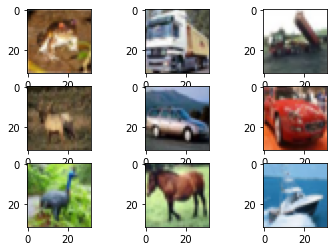

In [3]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

To TENSOR



In [4]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


Creo train_set, valid_set

In [5]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


Creo train_loader, valid_loader y test_loader

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)

Definicion de la red neuronal


In [17]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=512, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
      




In [18]:
conv_model = ConvModel()

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Linear-9                  [-1, 100]          51,300
           Linear-10                   [-1, 10]           1,010
Total params: 149,750
Trainable params: 149,750
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 0.57
Estimated T

Defino optimizador, una función de error y una función de métrica.

In [19]:
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.01)

loss =  torch.nn.CrossEntropyLoss()

accuracy = torchmetrics.Accuracy()

Creo un objeto SummaryWriter para almacenar los logs que se visualizan en Tensorboard.



In [20]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [22]:
conv_model_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

conv_model_loss = torch.nn.CrossEntropyLoss()

conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
    conv_model_accuracy.to("cuda")

epochs = 20

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []


for epoch in range(epochs):

    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0

    for train_data, train_target in train_loader:
        
        if torch.cuda.is_available():
            train_data = train_data.to("cuda")
            train_target = train_target.to("cuda")

        conv_model_optimizer.zero_grad()
    
        output = conv_model(train_data)
    
        loss = conv_model_loss(output, train_target)
        epoch_train_loss += loss.item()
        loss.backward()
    
        conv_model_optimizer.step()

        accuracy = conv_model_accuracy(output, train_target)
        epoch_train_accuracy += accuracy.item()

  
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_accuracy)

 
    epoch_valid_loss = 0.0
    epoch_valid_accuracy = 0.0

    for valid_data, valid_target in valid_loader:
        if torch.cuda.is_available():
            valid_data = valid_data.to("cuda")
            valid_target = valid_target.to("cuda")
 
        output = conv_model(valid_data)
        epoch_valid_loss += conv_model_loss(output, valid_target).item()
        epoch_valid_accuracy += conv_model_accuracy(output, valid_target).item()
      
    epoch_valid_loss = epoch_valid_loss / len(valid_loader)
    epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_accuracy)

    print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/20 - Train loss 1.667862 - Train Accuracy 0.380930 - Valid Loss 1.382328 - Valid Accuracy 0.503000
Epoch: 2/20 - Train loss 1.277584 - Train Accuracy 0.534226 - Valid Loss 1.147556 - Valid Accuracy 0.582800
Epoch: 3/20 - Train loss 1.073358 - Train Accuracy 0.616560 - Valid Loss 1.035558 - Valid Accuracy 0.627400
Epoch: 4/20 - Train loss 0.940871 - Train Accuracy 0.665134 - Valid Loss 0.967586 - Valid Accuracy 0.660200
Epoch: 5/20 - Train loss 0.850274 - Train Accuracy 0.700871 - Valid Loss 0.905405 - Valid Accuracy 0.684000
Epoch: 6/20 - Train loss 0.773387 - Train Accuracy 0.728434 - Valid Loss 0.984606 - Valid Accuracy 0.657200
Epoch: 7/20 - Train loss 0.714250 - Train Accuracy 0.748978 - Valid Loss 0.858840 - Valid Accuracy 0.706800
Epoch: 8/20 - Train loss 0.656252 - Train Accuracy 0.768146 - Valid Loss 0.846939 - Valid Accuracy 0.715000
Epoch: 9/20 - Train loss 0.606662 - Train Accuracy 0.785825 - Valid Loss 0.925834 - Valid Accuracy 0.693000
Epoch: 10/20 - Train loss 0.

Evaluo el comportamiento de las metricas

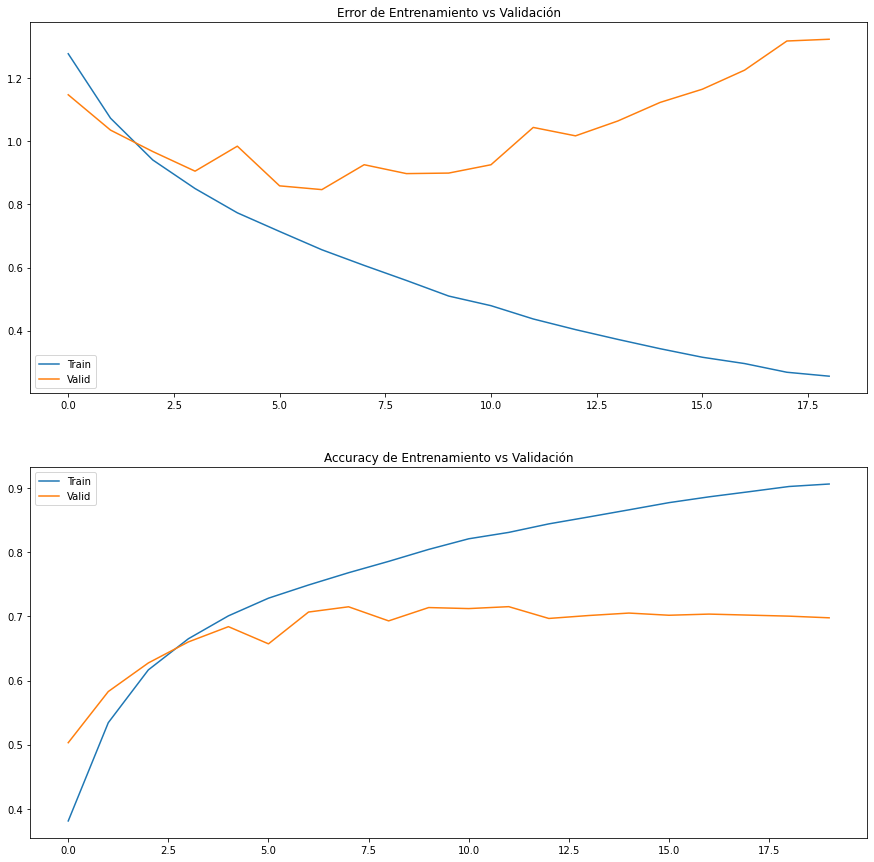

In [23]:

fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [25]:
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
    if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
        
    output = conv_model(test_data)
    test_loss += conv_model_loss(output, test_target).item()
    test_accuracy += conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El error del modelo es {:.6f}. El accuracy del modelo es {:.6f}".format(test_loss, test_accuracy))

El error del modelo es 1.348430. El accuracy del modelo es 0.688900


Se puede observar que existe un sobreentrenamiento del modelo debido a la poca cantidad de datos utilizados para el entrenamiento

Agrego Data Augmentation


In [28]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                        torchvision.transforms.ToTensor(),
                      ])

aug_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= aug_data_transforms)

Files already downloaded and verified


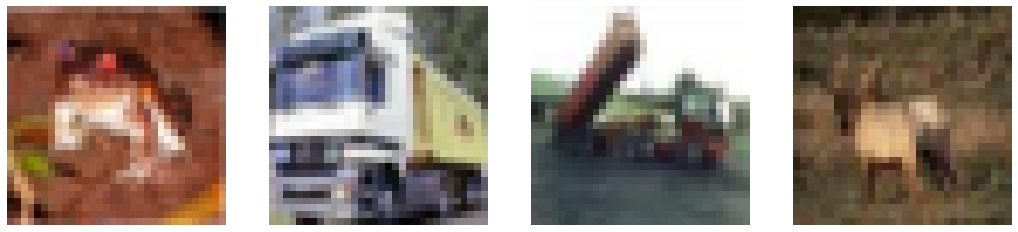

In [29]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[id][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

In [30]:
aug_valid_set_size = 5000

aug_train_set, aug_valid_set = torch.utils.data.random_split(aug_train_set, [len(aug_train_set) - aug_valid_set_size, aug_valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(aug_train_set)))
print("Tamaño del conjunto de validación: {}".format(len(aug_valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [32]:
aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=45, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=len(valid_set), shuffle=True)

In [33]:
aug_conv_model = ConvModel()

if torch.cuda.is_available():
  aug_conv_model = aug_conv_model.to("cuda")

aug_conv_model_optimizer = torch.optim.Adam(aug_conv_model.parameters(), lr=0.0001)

aug_conv_model_loss = torch.nn.CrossEntropyLoss()

aug_conv_model_accuracy = torchmetrics.Accuracy()

if torch.cuda.is_available():
  aug_conv_model_accuracy = aug_conv_model_accuracy.to("cuda")

# Epocas de entrenamiento
epochs = 40

# Defino listas para realizar graficas de los resultados
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

## Defino mi loop de entrenamiento

for epoch in range(epochs):

  epoch_train_loss = 0.0
  epoch_train_accuracy = 0.0

  for aug_train_data, aug_train_target in aug_train_loader:

    if torch.cuda.is_available():
      aug_train_data = aug_train_data.to("cuda")
      aug_train_target = aug_train_target.to("cuda")

    aug_conv_model_optimizer.zero_grad()
    
    aug_output = aug_conv_model(aug_train_data)
    
    aug_loss = aug_conv_model_loss(aug_output, aug_train_target)
    epoch_train_loss += aug_loss.item()
    aug_loss.backward()
    
    aug_conv_model_optimizer.step()
    accuracy = aug_conv_model_accuracy(aug_output, aug_train_target)
    epoch_train_accuracy += accuracy.item()

  # Calculo la media de error y accuracy para la epoca de entrenamiento.
  # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
  epoch_train_loss = epoch_train_loss / len(aug_train_loader)
  epoch_train_accuracy = epoch_train_accuracy / len(aug_train_loader)
  train_loss.append(epoch_train_loss)
  train_acc.append(epoch_train_accuracy)

  # Realizo el paso de validación computando error y accuracy, y
  # almacenando los valores para imprimirlos y graficarlos
  epoch_valid_loss = 0.0
  epoch_valid_accuracy = 0.0

  for aug_valid_data, aug_valid_target in aug_valid_loader:
    if torch.cuda.is_available():
      aug_valid_data = aug_valid_data.to("cuda")
      aug_valid_target = aug_valid_target.to("cuda")

    aug_output = aug_conv_model(aug_valid_data)
    epoch_valid_loss += aug_conv_model_loss(aug_output, aug_valid_target).item()
    epoch_valid_accuracy += aug_conv_model_accuracy(aug_output, aug_valid_target).item()
      
  epoch_valid_loss = epoch_valid_loss / len(aug_valid_loader)
  epoch_valid_accuracy = epoch_valid_accuracy / len(aug_valid_loader)
  valid_loss.append(epoch_valid_loss)
  valid_acc.append(epoch_valid_accuracy)

  print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
      epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

Epoch: 1/40 - Train loss 2.017589 - Train Accuracy 0.255067 - Valid Loss 1.857292 - Valid Accuracy 0.326600
Epoch: 2/40 - Train loss 1.724414 - Train Accuracy 0.368178 - Valid Loss 1.680201 - Valid Accuracy 0.377600
Epoch: 3/40 - Train loss 1.600274 - Train Accuracy 0.415867 - Valid Loss 1.576643 - Valid Accuracy 0.423800
Epoch: 4/40 - Train loss 1.530911 - Train Accuracy 0.440889 - Valid Loss 1.508758 - Valid Accuracy 0.442600
Epoch: 5/40 - Train loss 1.482386 - Train Accuracy 0.461622 - Valid Loss 1.483721 - Valid Accuracy 0.450600
Epoch: 6/40 - Train loss 1.445947 - Train Accuracy 0.476889 - Valid Loss 1.438857 - Valid Accuracy 0.472000
Epoch: 7/40 - Train loss 1.409108 - Train Accuracy 0.490622 - Valid Loss 1.428416 - Valid Accuracy 0.481400
Epoch: 8/40 - Train loss 1.379061 - Train Accuracy 0.501511 - Valid Loss 1.439378 - Valid Accuracy 0.469200
Epoch: 9/40 - Train loss 1.353370 - Train Accuracy 0.513622 - Valid Loss 1.379704 - Valid Accuracy 0.498000
Epoch: 10/40 - Train loss 1.

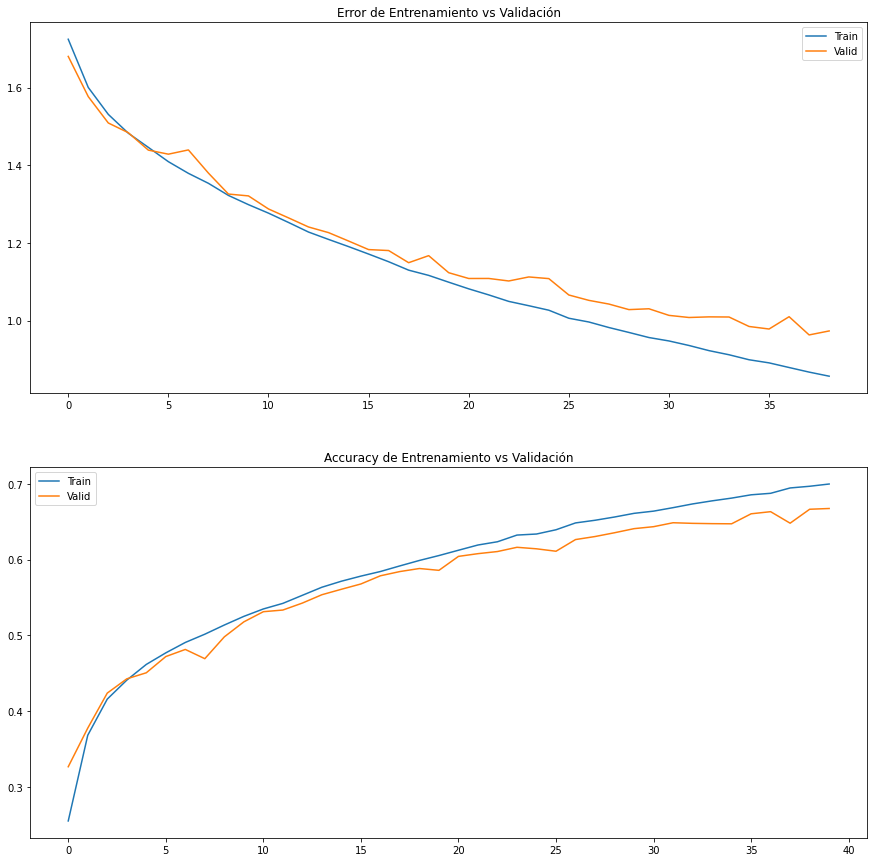

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(train_loss[1:]) 
axs[0].plot(valid_loss[1:]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(train_acc) 
axs[1].plot(valid_acc) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

In [35]:
test_loss = 0.0
test_accuracy = 0.0

for test_data, test_target in test_loader:
    
    if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
    output = aug_conv_model(test_data)
    test_loss += aug_conv_model_loss(output, test_target).item()
    test_accuracy += aug_conv_model_accuracy(output, test_target).item()

test_loss = test_loss / len(test_loader)
test_accuracy = test_accuracy / len(test_loader)

print("El error del modelo es {:.6f}. El accuracy del modelo es {:.6f}".format(test_loss, test_accuracy))



El error del modelo es 0.943040. El accuracy del modelo es 0.667600


El entrenamiento es mas lento debido a las transformaciones aplicadas. Se intentara correr con 60 epocas para ver si mejoran las metricas sin incurrir en overfitting.
